# PROJECT: CLIMATE CHANGE

In [66]:
# import all the libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import sklearn
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm





In [67]:
# read all the global land temperatures by characteristics + Co2 emissions
df_country= pd.read_csv("data/GlobalLandTemperaturesByCountry.csv")
df_general = pd.read_csv("data/GlobalTemperatures.csv")
df_emissions = pd.read_csv("data/owid-co2-data.csv")



## 1. EDA:


### EDA: Data wrangling for `df_country`:

In [68]:
df_country.head()



,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [69]:
df_country.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe
577461,2013-09-01,NaN,NaN,Zimbabwe


In [70]:
df_country.describe(include = "all")


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
count,577462,544811.000000,545550.000000,577462
unique,3239,NaN,NaN,243
top,2013-09-01,NaN,NaN,Åland
freq,243,NaN,NaN,3239
mean,NaN,17.193354,1.019057,NaN
std,NaN,10.953966,1.201930,NaN
min,NaN,-37.658000,0.052000,NaN
25%,NaN,10.025000,0.323000,NaN
50%,NaN,20.901000,0.571000,NaN
75%,NaN,25.814000,1.206000,NaN


In [71]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


from `df_country.info()`, we have: 
| Column                          | Storage Type | Feature Type               | Notes                                                              |

|--------------------------------|--------------|----------------------------|--------------------------------------------------------------------|
| `dt`                           | object       | Temporal (Date)            | Should be converted to `datetime64` for proper time series use.   |
| `AverageTemperature`           | float64      | Quantitative (Continuous)  | Represents average land temperature, continuous values.            |
| `AverageTemperatureUncertainty`| float64      | Quantitative (Continuous)  | Measurement uncertainty, also continuous.                          |
| `Country`                      | object       | Qualitative (Nominal)      | Categorical — country names, no inherent order.                    |

### Quality checks:


In [72]:
print(df_country.shape)
print("Total countries:", df_country['Country'].nunique())
print("Total months:", df_country['dt'].nunique())


(577462, 4)
Total countries: 243
Total months: 3239


In [73]:
### a general function: choropleth map: better to see whether the data is well-cleaning or not.
def plot_country_choropleth(
    df,
    country_col='Country',
    value_col=None,
    aggfunc='count',
    title='Choropleth Map by Country',
    color_scale='viridis'
):
    """
    Creates a choropleth map using Plotly based on country-level data.

    Parameters:
    - df: pandas.DataFrame
    - country_col: str, name of the country column
    - value_col: str or None, column to aggregate (if None, count is used)
    - aggfunc: str, aggregation function (e.g., 'mean', 'sum', 'count')
    - title: str, plot title
    - color_scale: str, Plotly color scale name
    """
    if value_col:
        df_agg = df.groupby(country_col)[value_col].agg(aggfunc).reset_index()
        df_agg.columns = [country_col, 'Value']
    else:
        df_agg = df[country_col].value_counts().reset_index()
        df_agg.columns = [country_col, 'Value']

    fig = px.choropleth(
        df_agg,
        locations=country_col,
        locationmode='country names',
        color='Value',
        color_continuous_scale=color_scale,
        title=title
    )

    fig.update_layout(
        coloraxis_colorbar=dict(title='Value'),
        margin=dict(l=0, r=0, t=50, b=0)
    )

    fig.show()

In [74]:
plot_country_choropleth(df_country,
                        title='Number of Temperature Records by Country(All RECORDS)',)

### Conclusion on the Shape of the Data

Taking a moment to assess the quality and structure of the dataset,  we observe that the data is chronologically ordered, beginning in **November 1743** and ending in **September 2013**. This implies that, in theory, the number of expected records should be:

$$
\text{Total records} = \text{Total unique countries} \times \text{Total months} = 243 \times 3239 = 787{,}077
$$

However, as seen from the `df_country.shape`, there are only **577,462** records available. This indicates that roughly **26%** of the possible country-month observations are missing.

After inspecting the raw data (sourced from Berkeley Earth), it's evident that many of these missing values are concentrated in **remote territories**, as well as **countries in Asia and Africa**, particularly in the earlier years. Moreover, **from the chorolegraph map,** it is clear that those areas have many missing records in the early.

=> **Solution: `drop records`** reasonable to restrict the analysis to data from **1900 onward**(significantly reduces the sparsity and improves data reliability.):

In [75]:
df_country['dt'] = pd.to_datetime(df_country['dt'])
df_country_clean = df_country[df_country['dt'].dt.year >=1900]
df_country_clean

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
1874,1900-01-01,-3.026,0.538,Åland
1875,1900-02-01,-8.063,0.657,Åland
1876,1900-03-01,-3.196,0.467,Åland
1877,1900-04-01,0.781,0.224,Åland
1878,1900-05-01,4.960,0.503,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [76]:
df_country_clean.isnull().sum()

dt                                  0
AverageTemperature               1050
AverageTemperatureUncertainty     311
Country                             0
dtype: int64

#### Final touch: no more missing value:
Because this is a time-series dataset, filling the < 1 % temperature gaps with an overall mean

=> Safely remove the rows with missing value



In [77]:
df_country_clean = df_country_clean.dropna(subset=['AverageTemperature'])


 Drawing a choropleth map to show that the data are well-cleaning:

In [78]:
### Choropleth map: number of temperature records

plot_country_choropleth(df_country_clean,
                        title='Number of Temperature Records by Country (from 1900)')

#### RQ: How does the average temperature vary across different countries globally?

In [79]:
plot_country_choropleth(df_country_clean,
                        value_col= 'AverageTemperature',
                        aggfunc = 'mean',
                        title = 'Average Temperature of Countries')

**Comments**: The world map is reasonable and meaningful reflecting climate zones:
- Equatorial regions: higher average temperatures( yellow mostly) => Tropical climates
- Northern countries: cooler 
- Desert regions: shows high values, which is the same with the expectation

### RQ: What is the country with minimum average temperature?


In [80]:
df_country_clean[df_country_clean['AverageTemperature']== df_country_clean['AverageTemperature'].min()]

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
211035,1918-01-01,-37.177,4.248,Greenland


**Greenland** is the country with the min average temperature. Visualizing the temporal analysis for Greenland to answer the sub-question: 
   - "To what extent has Greenland’s seasonal temperature profile changed over the last century?(1900-2012)"

In [81]:
def plot_country_temperature(df, country, year1, year2):
    """
    Interactive Plotly line plot comparing monthly average temperatures
    for a country in two different years.

    Parameters:
    - df: DataFrame with ['Country', 'dt', 'AverageTemperature']
    - country: str, e.g., 'Kuwait'
    - year1: int, e.g., 1900
    - year2: int, e.g., 2012
    """
    df = df[df['Country'] == country].copy()
    df.dropna(subset=['AverageTemperature', 'dt'], inplace=True)
    df['dt'] = pd.to_datetime(df['dt'])
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month

    df_filtered = df[df['year'].isin([year1, year2])].copy()

    # Group by year and month, then compute average temperature
    df_grouped = df_filtered.groupby(['year', 'month'])['AverageTemperature'].mean().reset_index()

    # Plot
    fig = px.line(
        df_grouped,
        x='month',
        y='AverageTemperature',
        color='year',
        labels={
            'month': 'Month',
            'AverageTemperature': 'Average Temperature (°C)',
            'year': 'Year'
        },
        title=f'Monthly Average Temperature in {country} ({year1} vs {year2})'
    )

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=[
            'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
        ]),
        margin=dict(l=0, r=0, t=50, b=0)
    )

    fig.show()

In [82]:
plot_country_temperature(df_country_clean, 'Greenland', 1900, 2012)

c:\Users\Admin\anaconda3\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



From the interactive plot, it is interesting to see that the average temperature in Greenland peaks aroung July 1st, follwoing a seasonal pattern typical of polar climate
Ref: "In-text citation:

(NOAA Arctic Report Card, 2024)

Full reference (APA 7th edition):

NOAA Arctic Report Card. (2024). Greenland Ice Sheet. In Arctic Report Card 2024. National Oceanic and Atmospheric Administration. Retrieved June 21, 2025, from NOAA Arctic Report Card website."

#### RQ: What is the country with the maximum average temperature?


In [83]:
df_country_clean[df_country_clean['AverageTemperature']==df_country_clean['AverageTemperature'].max()]

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
284851,2012-07-01,38.842,0.464,Kuwait


Kuwait is the answer

In [84]:
plot_country_temperature(df_country_clean, 'Kuwait', 1900,2012)

c:\Users\Admin\anaconda3\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



A comparison of Greenland (polar) and Kuwait (desert/subtropical) from 1900 to 2012 shows:

- Warming across nearly all months, especially in summer

- Peak temperatures increased:

     - Greenland: from –1.4 °C to 0.3 °C

     - Kuwait: from 35.8 °C to 38.8 °C

- These changes reflect patterns expected under climate change, including:

     - Rising global average temperatures

     - Warmer summers and milder winters

     - More extreme seasonal conditions in some regions

The consistent rise in monthly average temperatures across such different climates provides strong supporting evidence for global warming

The plot displays correclty a desert/sub-tropical climate should be.

In [85]:
def plot_kde_temperature_comparison(df, countries, year):
    """
    Plots KDE curves of average temperature for multiple countries in a given year.

    Parameters:
    - df: DataFrame with 'Country', 'dt', 'AverageTemperature'
    - countries: list of country names, e.g. ['Kuwait', 'Greenland']
    - year: int, e.g. 2012
    """
    df = df[df['Country'].isin(countries)].copy()
    df.dropna(subset=['AverageTemperature', 'dt'], inplace=True)
    df['dt'] = pd.to_datetime(df['dt'])
    df['year'] = df['dt'].dt.year
    df = df[df['year'] == year]
    custom_palette = {'Greenland': 'skyblue', 'Kuwait': 'orange'}

    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=df,
        x='AverageTemperature',
        hue='Country',
        palette=custom_palette,
        fill=True,
        common_norm=False,
        alpha=0.5,
        linewidth=2
    )
    plt.title(f'KDE of Average Temperature in {", ".join(countries)} ({year})')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### What contrasts in seasonal temperature patterns emerge between Greenland and Kuwait, as revealed by their 2012 daily temperature distributions?”

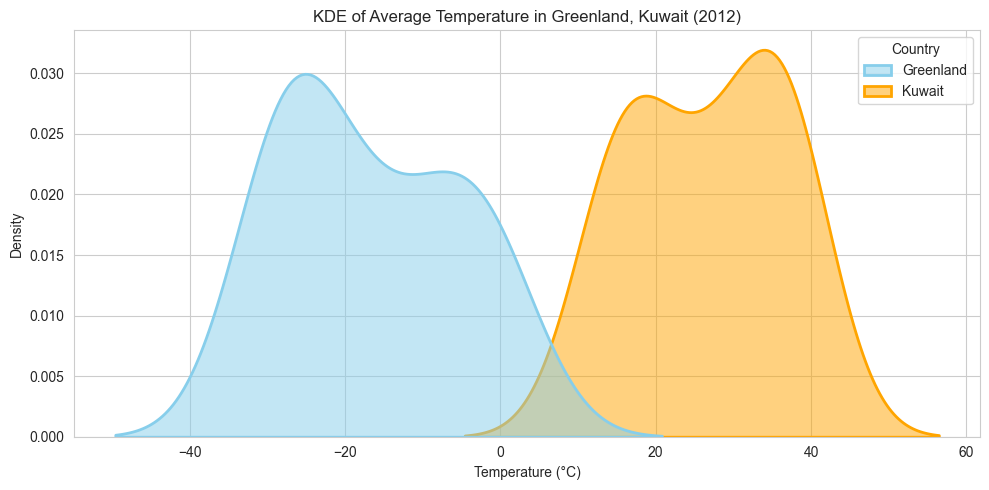

In [86]:
plot_kde_temperature_comparison(df_country_clean, ['Greenland', 'Kuwait'], 2012)


#### RQ: Seasonal Temperature: How have global average land temperatures changed seasonally over time?

### How has the average yearly temperature changed from 1900 to 2020?

C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\318254535.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



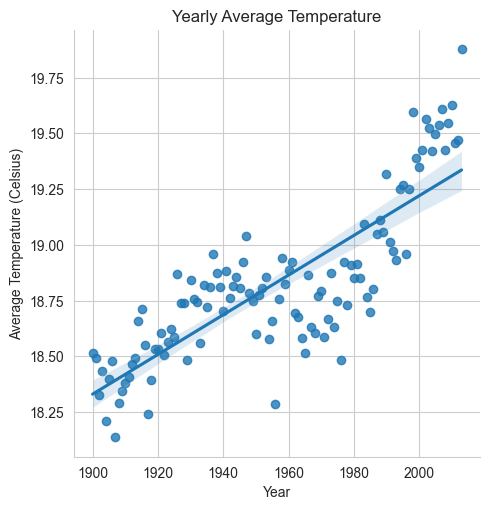

In [87]:
df_country_clean['Year'] = df_country_clean['dt'].dt.year
df_yearly_avg = df_country_clean.groupby('Year')['AverageTemperature'].mean().reset_index()

sns.lmplot(data=df_yearly_avg, x='Year', y='AverageTemperature', palette= 'viridis')
sns.set_style("whitegrid")
plt.title('Yearly Average Temperature')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celsius)')
plt.show()

The regression line in the plot **highlights a significant upward trend**, suggesting that the average temperature has steadily increased over the last century, consistent with **global warming patterns.**

### EDA for emissions:
- Description: 

In [88]:
df_emissions.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
df_emissions.tail()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
50186,Zimbabwe,2019,ZWE,15271377.0,2.514642e+10,0.473,0.031,10.263,-0.942,-8.411,...,NaN,0.106,0.001,0.001,0.002,0.0,34.348,17.531,-0.027,-0.261
50187,Zimbabwe,2020,ZWE,15526888.0,2.317871e+10,0.496,0.032,8.495,-1.768,-17.231,...,NaN,0.105,0.001,0.001,0.002,0.0,31.323,15.775,0.612,7.209
50188,Zimbabwe,2021,ZWE,15797220.0,2.514009e+10,0.531,0.034,10.204,1.709,20.120,...,NaN,0.104,0.001,0.001,0.002,0.0,33.549,17.599,0.539,5.280
50189,Zimbabwe,2022,ZWE,16069061.0,2.590159e+10,0.531,0.033,10.425,0.221,2.169,...,NaN,0.103,0.001,0.001,0.002,0.0,33.772,17.910,0.315,3.018
50190,Zimbabwe,2023,ZWE,16340829.0,NaN,0.531,0.032,11.164,0.739,7.090,...,NaN,0.102,0.001,0.001,0.002,0.0,33.955,18.608,NaN,NaN


Using the data ranging from 1990 to 2011

In [90]:
# get rid of sparse
df_emissions = df_emissions[df_emissions['year']>=1900]
df_emissions.shape


(31364, 79)

In [91]:
df_emissions

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
150,Afghanistan,1900,AFG,4707744.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.153,0.000,0.000,0.000,0.0,12.367,0.901,NaN,NaN
151,Afghanistan,1901,AFG,4751177.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.153,0.000,0.000,0.000,0.0,12.477,0.909,NaN,NaN
152,Afghanistan,1902,AFG,4802500.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.152,0.000,0.000,0.000,0.0,12.568,0.917,NaN,NaN
153,Afghanistan,1903,AFG,4861833.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.151,0.000,0.000,0.000,0.0,12.614,0.925,NaN,NaN
154,Afghanistan,1904,AFG,4921891.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.151,0.000,0.000,0.000,0.0,12.709,0.933,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50186,Zimbabwe,2019,ZWE,15271377.0,2.514642e+10,0.473,0.031,10.263,-0.942,-8.411,...,NaN,0.106,0.001,0.001,0.002,0.0,34.348,17.531,-0.027,-0.261
50187,Zimbabwe,2020,ZWE,15526888.0,2.317871e+10,0.496,0.032,8.495,-1.768,-17.231,...,NaN,0.105,0.001,0.001,0.002,0.0,31.323,15.775,0.612,7.209
50188,Zimbabwe,2021,ZWE,15797220.0,2.514009e+10,0.531,0.034,10.204,1.709,20.120,...,NaN,0.104,0.001,0.001,0.002,0.0,33.549,17.599,0.539,5.280
50189,Zimbabwe,2022,ZWE,16069061.0,2.590159e+10,0.531,0.033,10.425,0.221,2.169,...,NaN,0.103,0.001,0.001,0.002,0.0,33.772,17.910,0.315,3.018


In [92]:
df_emissions.isnull().sum()

country                            0
year                               0
iso_code                        4332
population                      3860
gdp                            17578
                               ...  
temperature_change_from_n2o     4084
total_ghg                       4704
total_ghg_excluding_lucf        4828
trade_co2                      26829
trade_co2_share                26829
Length: 79, dtype: int64

#### Handling the missing values:
Drop the columns contain >= 30%  missing data points

In [93]:
df_emissions = df_emissions.dropna(
    axis=1,
    thresh=int(len(df_emissions) * 0.3)  
)
df_emissions.shape



(31364, 68)

In [94]:
print(df_emissions.columns)
df_emissions

Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'energy_per_capita', 'flaring_co2',
       'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita',
       'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane',
       'methane_per_capita', 'nitrous_oxide', 'nitrous_oxide_per_capita',
       'oil_co2', 'oi

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf
150,Afghanistan,1900,AFG,4707744.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.131,NaN,0.153,0.000,0.000,0.000,0.0,12.367,0.901
151,Afghanistan,1901,AFG,4751177.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.132,NaN,0.153,0.000,0.000,0.000,0.0,12.477,0.909
152,Afghanistan,1902,AFG,4802500.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.130,NaN,0.152,0.000,0.000,0.000,0.0,12.568,0.917
153,Afghanistan,1903,AFG,4861833.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.131,NaN,0.151,0.000,0.000,0.000,0.0,12.614,0.925
154,Afghanistan,1904,AFG,4921891.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.129,NaN,0.151,0.000,0.000,0.000,0.0,12.709,0.933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50186,Zimbabwe,2019,ZWE,15271377.0,2.514642e+10,0.473,0.031,10.263,-0.942,-8.411,...,NaN,0.252,0.030,0.106,0.001,0.001,0.002,0.0,34.348,17.531
50187,Zimbabwe,2020,ZWE,15526888.0,2.317871e+10,0.496,0.032,8.495,-1.768,-17.231,...,NaN,0.260,0.028,0.105,0.001,0.001,0.002,0.0,31.323,15.775
50188,Zimbabwe,2021,ZWE,15797220.0,2.514009e+10,0.531,0.034,10.204,1.709,20.120,...,NaN,0.241,0.032,0.104,0.001,0.001,0.002,0.0,33.549,17.599
50189,Zimbabwe,2022,ZWE,16069061.0,2.590159e+10,0.531,0.033,10.425,0.221,2.169,...,NaN,0.227,0.028,0.103,0.001,0.001,0.002,0.0,33.772,17.910


From the `df_emissions.info()`, we have the important feature types:
| Column           | Storage Type | Feature Type               | Notes                                                                 |
|------------------|--------------|----------------------------|-----------------------------------------------------------------------|
| `country`        | object       | Qualitative (Nominal)      | Country names; can include aggregates like "World", "Asia", etc.      |
| `iso_code`       | object       | Qualitative (Nominal)      | ISO-3 country codes; used for consistent joining and plotting.        |
| `year`           | int64        | Temporal (Year)            | Year of the observation.                                              |
| `co2`            | float64      | Quantitative (Continuous)  | Total CO₂ emissions (million tonnes).                                 |
| `co2_per_capita` | float64      | Quantitative (Continuous)  | CO₂ emissions per person (tonnes/person).                             |
| `cement_co2`     | float64      | Quantitative (Continuous)  | CO₂ emissions from cement production (million tonnes).                |
| `population`     | float64      | Quantitative (Continuous)  | Total population estimate for that country and year.                  |
| `gdp`            | float64      | Quantitative (Continuous)  | Gross domestic product (constant 2011 international dollars).         |
| `primary_energy_consumption` | float64 | Quantitative (Continuous) | Total primary energy consumption (TWh).                             |

### Adding the gdp per capita + primary energy per capita:

In [95]:
df_emissions['gdp_per_capita'] = df_emissions['gdp'] / df_emissions['population']

df_emissions['gdp_per_capita'] = df_emissions['gdp_per_capita'].round(3) 


df_emissions

C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\2550723929.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\2550723929.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_luc_co2,share_global_oil_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,gdp_per_capita
150,Afghanistan,1900,AFG,4707744.0,NaN,0.000,0.000,NaN,NaN,NaN,...,0.131,NaN,0.153,0.000,0.000,0.000,0.0,12.367,0.901,NaN
151,Afghanistan,1901,AFG,4751177.0,NaN,0.000,0.000,NaN,NaN,NaN,...,0.132,NaN,0.153,0.000,0.000,0.000,0.0,12.477,0.909,NaN
152,Afghanistan,1902,AFG,4802500.0,NaN,0.000,0.000,NaN,NaN,NaN,...,0.130,NaN,0.152,0.000,0.000,0.000,0.0,12.568,0.917,NaN
153,Afghanistan,1903,AFG,4861833.0,NaN,0.000,0.000,NaN,NaN,NaN,...,0.131,NaN,0.151,0.000,0.000,0.000,0.0,12.614,0.925,NaN
154,Afghanistan,1904,AFG,4921891.0,NaN,0.000,0.000,NaN,NaN,NaN,...,0.129,NaN,0.151,0.000,0.000,0.000,0.0,12.709,0.933,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50186,Zimbabwe,2019,ZWE,15271377.0,2.514642e+10,0.473,0.031,10.263,-0.942,-8.411,...,0.252,0.030,0.106,0.001,0.001,0.002,0.0,34.348,17.531,1646.637
50187,Zimbabwe,2020,ZWE,15526888.0,2.317871e+10,0.496,0.032,8.495,-1.768,-17.231,...,0.260,0.028,0.105,0.001,0.001,0.002,0.0,31.323,15.775,1492.811
50188,Zimbabwe,2021,ZWE,15797220.0,2.514009e+10,0.531,0.034,10.204,1.709,20.120,...,0.241,0.032,0.104,0.001,0.001,0.002,0.0,33.549,17.599,1591.425
50189,Zimbabwe,2022,ZWE,16069061.0,2.590159e+10,0.531,0.033,10.425,0.221,2.169,...,0.227,0.028,0.103,0.001,0.001,0.002,0.0,33.772,17.910,1611.892


### Population Growth: 


​
 	

In [96]:
df_emissions['population_growth'] = df_emissions.groupby('country')['population'].pct_change() * 100
df_emissions

C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\2578548878.py:1: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\2578548878.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_oil_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,gdp_per_capita,population_growth
150,Afghanistan,1900,AFG,4707744.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.153,0.000,0.000,0.000,0.0,12.367,0.901,NaN,NaN
151,Afghanistan,1901,AFG,4751177.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.153,0.000,0.000,0.000,0.0,12.477,0.909,NaN,0.922586
152,Afghanistan,1902,AFG,4802500.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.152,0.000,0.000,0.000,0.0,12.568,0.917,NaN,1.080217
153,Afghanistan,1903,AFG,4861833.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.151,0.000,0.000,0.000,0.0,12.614,0.925,NaN,1.235461
154,Afghanistan,1904,AFG,4921891.0,NaN,0.000,0.000,NaN,NaN,NaN,...,NaN,0.151,0.000,0.000,0.000,0.0,12.709,0.933,NaN,1.235295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50186,Zimbabwe,2019,ZWE,15271377.0,2.514642e+10,0.473,0.031,10.263,-0.942,-8.411,...,0.030,0.106,0.001,0.001,0.002,0.0,34.348,17.531,1646.637,1.575847
50187,Zimbabwe,2020,ZWE,15526888.0,2.317871e+10,0.496,0.032,8.495,-1.768,-17.231,...,0.028,0.105,0.001,0.001,0.002,0.0,31.323,15.775,1492.811,1.673137
50188,Zimbabwe,2021,ZWE,15797220.0,2.514009e+10,0.531,0.034,10.204,1.709,20.120,...,0.032,0.104,0.001,0.001,0.002,0.0,33.549,17.599,1591.425,1.741057
50189,Zimbabwe,2022,ZWE,16069061.0,2.590159e+10,0.531,0.033,10.425,0.221,2.169,...,0.028,0.103,0.001,0.001,0.002,0.0,33.772,17.910,1611.892,1.720815


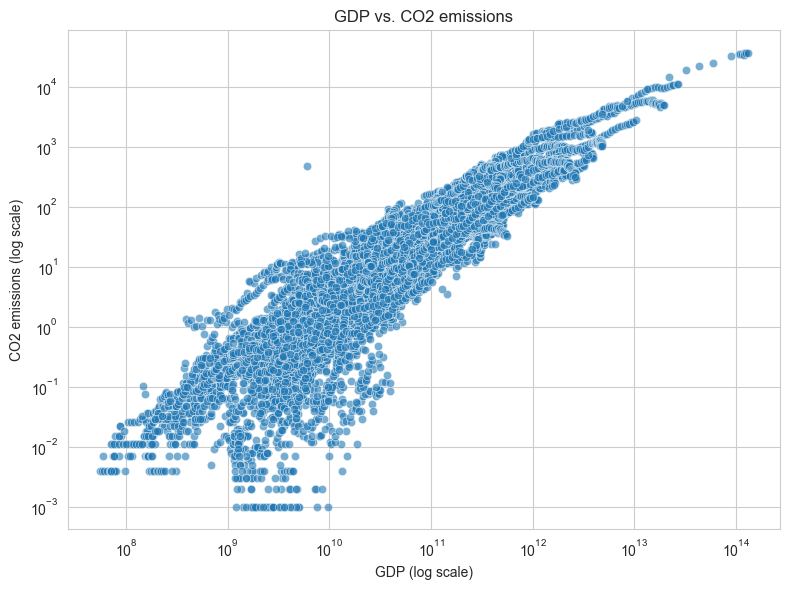

In [97]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_emissions[['gdp','co2']].dropna(), x='gdp', y='co2', alpha=0.6)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('GDP (log scale)')
plt.ylabel('CO2 emissions (log scale)')
plt.title('GDP vs. CO2 emissions')
plt.tight_layout()
plt.show()

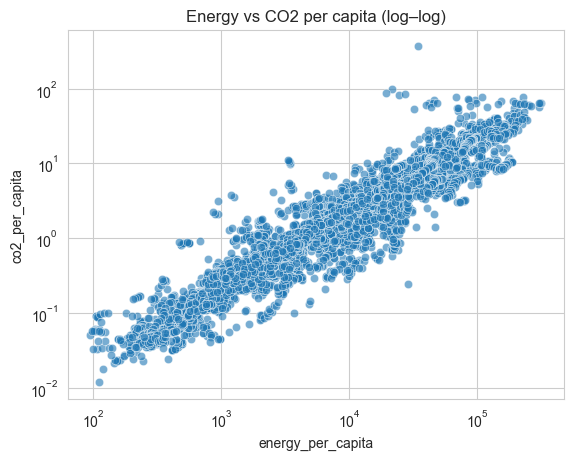

In [215]:
sns.scatterplot(data=df_emissions, x='energy_per_capita', y='co2_per_capita', alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.title('Energy vs CO2 per capita (log–log)')
plt.show()

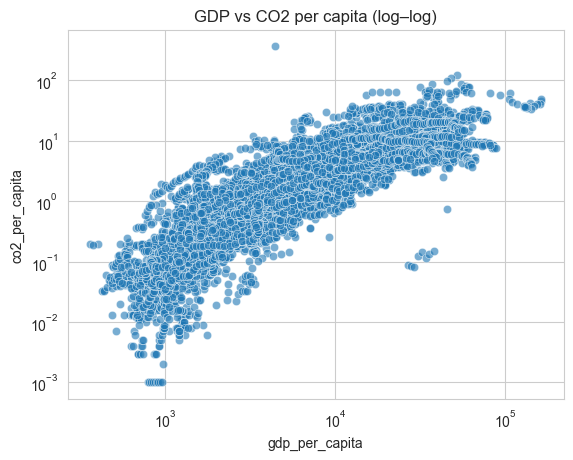

In [218]:
sns.scatterplot(data=df_emissions, x='gdp_per_capita', y='co2_per_capita', alpha = 0.6)
plt.xscale('log'); plt.yscale('log')
plt.title('GDP vs CO2 per capita (log–log)')
plt.show()

#### Conclusion:
- Raising number of Co2 do happens

### RQ: Which regions or economic blocs were the top $CO_2$ emitters in the most recent year, based on OWID aggregate groups?

In [99]:
def top_emitters(df,start, end, level,  metric="co2", top_n=5):
    """
    Return the top-N emitters for a given period.

    Parameters
    ----------
    df : pandas.DataFrame
        OWID / GCP emissions table. Must contain columns
        'year', 'country', 'iso_code', and the metric column.
    start_year, end_year : int
        Inclusive year boundaries (e.g. 2013, 2023).
    level : {"aggregate", "country"}
        aggregate – OWID/GCP group rows (iso_code is missing OR starts 'OWID_').
        country   – ISO-3166 alpha-3 rows only (len == 3, all A-Z).
    metric : str, default "co2"
        Column to sum.
    top_n : int, default 5
        How many rows to return.
    """

    df = df.copy()
    df.loc[df["iso_code"] == "", "iso_code"] = np.nan

    recent = df[(df["year"] >= start) & (df["year"] <= end)]

    
    if level == "country":
        mask = (
            recent["iso_code"].notna()
            & recent["iso_code"].str.fullmatch(r"[A-Z]{3}")
        )
    elif level == "aggregate":
        mask = pd.Series(True, index=recent.index)
    else:
        raise ValueError("level must be 'aggregate' or 'country'")

    subset = recent[mask]

    cumulative = (
        subset.groupby("country")[metric]
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .reset_index()
        .rename(
            columns={metric: f"cumulative_{metric}_{start}_{end}"}
        )
    )

    return cumulative

In [100]:
agg_top5 = top_emitters(df_emissions, 2013, 2023, level="aggregate")
print(agg_top5)

                         country  cumulative_co2_2013_2023
0                          World                398601.568
1                 Non-OECD (GCP)                252187.202
2                           Asia                223525.662
3                     Asia (GCP)                195011.016
4  Upper-middle-income countries                176459.532


In [101]:
fig = px.bar(
    agg_top5, 
    x="country",
    y="cumulative_co2_2013_2023",
    color="country",  
    text="cumulative_co2_2013_2023",  
    title="Cumulative CO₂ Emissions (2013–2023) by Aggregation",
    labels={"cumulative_co2_2013_2023": "Cumulative CO2 (Mt)", "country": "Aggregation"},
)
fig.update_traces(texttemplate='%{text:.2f}')

fig.show()


c:\Users\Admin\anaconda3\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



So, we know that Non-OECD(GCP) has the most co2 releasing in 10 years. Therefore, investigating the next aspect:
### Which countries are the top emitters in the recent ten years?(2013-2023)

In [102]:
# Top 5 individual countries, 2013-2023
country_top5 = top_emitters(df_emissions, 2013, 2023, level="country")
print(country_top5)

         country  cumulative_co2_2013_2023
0          China                116232.723
1  United States                 57227.450
2          India                 27354.136
3         Russia                 18600.639
4          Japan                 12564.790


In [103]:
fig = px.bar(
    country_top5,  
    x="country",
    y="cumulative_co2_2013_2023",
    color="country",  
    text="cumulative_co2_2013_2023",  
    title="Cumulative CO₂ Emissions (2013–2023) by Country/Region",
    labels={"cumulative_co2_2013_2023": "Cumulative CO2 (Mt)", "country": "Country"},
)
fig.update_traces(texttemplate='%{text:.2f}')

fig.show()

c:\Users\Admin\anaconda3\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



LinregressResult(slope=0.008897991393567816, intercept=1.4245474175166457, rvalue=0.8208769342226218, pvalue=5.157704860324023e-29, stderr=0.0005849529985536124, intercept_stderr=1.1446224150553486)


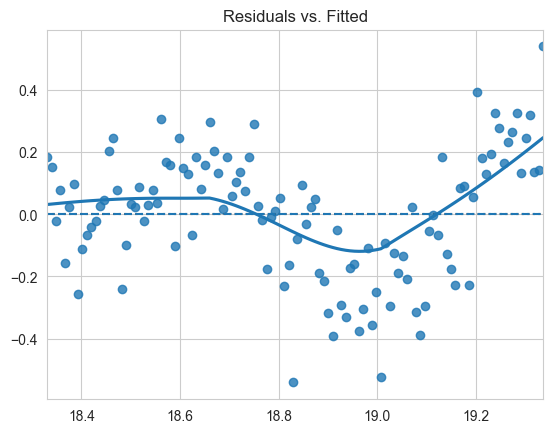

In [104]:
from scipy.stats import linregress

result = linregress(df_yearly_avg['Year'], df_yearly_avg['AverageTemperature'])
print(result)
# Fit model using statsmodels
X = df_yearly_avg['Year']
y = df_yearly_avg['AverageTemperature']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# 1. Residuals vs Fitted
residuals = model.resid
fitted = model.fittedvalues
sns.residplot(x=fitted, y=residuals, lowess=True)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs. Fitted')
plt.show()



In [105]:
# Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")

Durbin-Watson statistic: 0.758


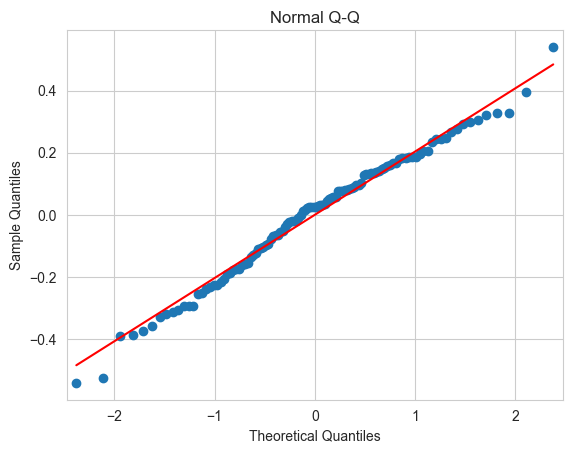

In [106]:
# 2. Normal Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q')
plt.show()

### Has the average annual temperature significantly increased when comparing the early 20th century to the early 21st century
- Testing hypothesis: 

    $H_0$: $\mu_{\text{early}} = \mu_{\text{recent}}$

    $H_a$: $\mu_{\text{early}} \ne \mu_{\text{recent}}$

In [107]:
from scipy.stats import ttest_ind
# 2-sample t-tests
early = df_yearly_avg[df_yearly_avg['Year'] < 1950]['AverageTemperature']
recent = df_yearly_avg[df_yearly_avg['Year'] >= 1950]['AverageTemperature']

t_stat, p_value = ttest_ind(early, recent, equal_var=False)  
print(f"t = {t_stat:.3f}, p-value = {p_value:.4e}")

t = -7.057, p-value = 1.8988e-10


### ML for Carbon Emissions Prediction: level country-wise:from 1950


In [108]:
df_emissions= df_emissions[df_emissions['year']>=1950]
df_emissions = df_emissions.dropna(subset=['iso_code'])
df_emissions

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_oil_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,gdp_per_capita,population_growth
200,Afghanistan,1950,AFG,7776182.0,9.421400e+09,0.000,0.000,0.084,0.070,475.000,...,0.004,0.128,0.000,0.000,0.001,0.0,19.447,1.453,1211.571,5.699310
201,Afghanistan,1951,AFG,7879343.0,9.692280e+09,0.000,0.000,0.092,0.007,8.696,...,0.004,0.128,0.000,0.000,0.001,0.0,20.458,1.473,1230.087,1.326628
202,Afghanistan,1952,AFG,7987783.0,1.001733e+10,0.000,0.000,0.092,0.000,0.000,...,0.003,0.128,0.000,0.000,0.001,0.0,21.356,1.484,1254.081,1.376257
203,Afghanistan,1953,AFG,8096703.0,1.063052e+10,0.000,0.000,0.106,0.015,16.000,...,0.004,0.128,0.000,0.000,0.001,0.0,22.361,1.517,1312.944,1.363582
204,Afghanistan,1954,AFG,8207953.0,1.086636e+10,0.000,0.000,0.106,0.000,0.000,...,0.003,0.128,0.000,0.000,0.001,0.0,23.256,1.534,1323.882,1.374016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50186,Zimbabwe,2019,ZWE,15271377.0,2.514642e+10,0.473,0.031,10.263,-0.942,-8.411,...,0.030,0.106,0.001,0.001,0.002,0.0,34.348,17.531,1646.637,1.575847
50187,Zimbabwe,2020,ZWE,15526888.0,2.317871e+10,0.496,0.032,8.495,-1.768,-17.231,...,0.028,0.105,0.001,0.001,0.002,0.0,31.323,15.775,1492.811,1.673137
50188,Zimbabwe,2021,ZWE,15797220.0,2.514009e+10,0.531,0.034,10.204,1.709,20.120,...,0.032,0.104,0.001,0.001,0.002,0.0,33.549,17.599,1591.425,1.741057
50189,Zimbabwe,2022,ZWE,16069061.0,2.590159e+10,0.531,0.033,10.425,0.221,2.169,...,0.028,0.103,0.001,0.001,0.002,0.0,33.772,17.910,1611.892,1.720815


#### Factors selection:

There are several factors contains the responsibility for increasing the amount of $CO_2$. Indeed, in this dataset, there are 51 unique indicators available which are provided by World Bank(after data wrangling). These indicators are related to the economy of a particular country. not necessarily related to carbon emissions only. Consequently, that leaves to a situation, where selecting an ideal indicators for processing becomes very crucial!

##### Multicolinearity:

Likely to happened between `cement_co2` and `cumulative_cement_co2` for example


In [109]:
from scipy.stats import kendalltau, spearmanr, pearsonr

subset = df_emissions[['cement_co2', 'cumulative_cement_co2']].dropna()
x = subset['cement_co2']
y = subset['cumulative_cement_co2']


# Pearson correlation (assumes linear relationship and normality)
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation (rank-based, good for monotonic relationships)
spearman_corr, spearman_p = spearmanr(x, y)

# Kendall Tau (more robust for small sample sizes or ties)
kendall_corr, kendall_p = kendalltau(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p = {pearson_p:.3e})")
print(f"Spearman correlation: {spearman_corr:.3f} (p = {spearman_p:.3e})")
print(f"Kendall Tau: {kendall_corr:.3f} (p = {kendall_p:.3e})")

Pearson correlation: 0.927 (p = 0.000e+00)
Spearman correlation: 0.972 (p = 0.000e+00)
Kendall Tau: 0.879 (p = 0.000e+00)


3 ways produce the same result => strongly positive correlated

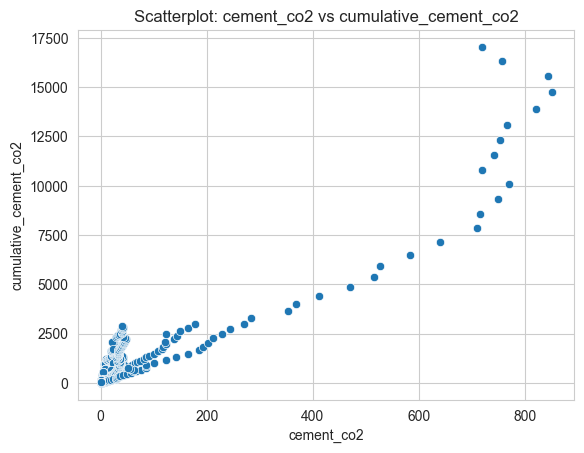

In [110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
sns.scatterplot(data=subset, x='cement_co2', y='cumulative_cement_co2')
plt.title('Scatterplot: cement_co2 vs cumulative_cement_co2')
plt.xlabel('cement_co2')
plt.ylabel('cumulative_cement_co2')
plt.show()


In [111]:
# VIF calculation
X_real = add_constant(df_emissions[['cement_co2', 'cumulative_cement_co2']].dropna())
vif_data = pd.DataFrame({
    'feature': X_real.columns,
    'VIF': [variance_inflation_factor(X_real.values, i) for i in range(X_real.shape[1])]
})
print(vif_data)

                 feature       VIF
0                  const  1.036673
1             cement_co2  7.112754
2  cumulative_cement_co2  7.112754


VIF >5 => get rid of cumulative cement co2

In [194]:
### chosen indicators

indicators = [
    'co2_per_capita',
    'year',
    'ghg_per_capita',
    'iso_code',
    'energy_per_capita',
    'co2_including_luc_per_capita',
    'co2_per_gdp',
    'methane_per_capita',
    'gas_co2_per_capita',
    'flaring_co2_per_capita'
]          # demographic factor

# Define the short indicator codes for renaming
indicator_codes = [
    'CO2_PC',
    'YEAR',
    'GHG',
    'ISO',
    'EN_PC',           # Energy per capita
    'CO2_LUC_PC',      # CO2 incl. land-use change per capita
    'CO2_PER_GDP',     # CO2 intensity of GDP
    'METHANE_PC',      # Methane per capita
    'GAS_CO2_PC',      # Gas CO2 per capita
    'FLARE_CO2_PC'     # Flaring CO2 per capita
]


In [195]:
# Keep only the indicators column
data = df_emissions[indicators].copy()
data


,co2_per_capita,year,ghg_per_capita,iso_code,energy_per_capita,co2_including_luc_per_capita,co2_per_gdp,methane_per_capita,gas_co2_per_capita,flaring_co2_per_capita
200,0.011,1950,2.501,AFG,NaN,0.941,0.009,1.042,0.0,NaN
201,0.012,1951,2.596,AFG,NaN,1.049,0.009,1.045,0.0,NaN
202,0.011,1952,2.674,AFG,NaN,1.151,0.009,1.048,0.0,NaN
203,0.013,1953,2.762,AFG,NaN,1.268,0.010,1.053,0.0,NaN
204,0.013,1954,2.833,AFG,NaN,1.357,0.010,1.059,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
50186,0.672,2019,2.249,ZWE,3003.655,1.297,0.408,0.848,NaN,0.0
50187,0.547,2020,2.017,ZWE,2680.132,1.123,0.366,0.814,NaN,0.0
50188,0.646,2021,2.124,ZWE,2635.154,1.187,0.406,0.826,NaN,0.0
50189,0.649,2022,2.102,ZWE,NaN,1.148,0.402,0.806,NaN,0.0


In [153]:

# Select only numeric columns
numeric_df = df_emissions.select_dtypes(include='number')

# Compute Pearson correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Extract correlations with co2_per_capita
co2_corr = corr_matrix['co2_per_capita'].drop('co2_per_capita').dropna()

# Filter correlations with absolute value <= 0.8
filtered_corr = co2_corr[co2_corr.abs() <= 0.8].sort_values(key=lambda x: x.abs(), ascending=False)
filtered_corr

ghg_per_capita                  0.788179
energy_per_capita               0.734732
co2_including_luc_per_capita    0.716002
co2_per_gdp                     0.620952
gdp_per_capita                  0.591641
                                  ...   
population                     -0.016086
co2_including_luc_per_gdp      -0.015432
year                           -0.015187
cement_co2                      0.010171
co2_growth_prct                -0.001734
Name: co2_per_capita, Length: 65, dtype: float64

In [196]:
years_count = data['year'].value_counts().sort_index().to_dict()
missing_by_year = data.groupby('year').apply(lambda x: x.isnull().sum().sum()).sort_values()

# Print nicely
print("Year : Missing values")
for year, missing in missing_by_year.items():
    print(f"{year} : {missing}")

Year : Missing values
2021 : 234
2019 : 234
2020 : 235
2018 : 235
2011 : 235
2010 : 236
2017 : 237
2015 : 237
2016 : 238
2014 : 238
2009 : 238
2013 : 239
2012 : 240
2008 : 241
2007 : 243
2006 : 243
2005 : 245
2004 : 246
2003 : 246
2002 : 248
2001 : 249
2000 : 251
1999 : 251
1998 : 252
1997 : 254
1996 : 255
1995 : 255
1994 : 257
2022 : 359
1992 : 396
1993 : 396
1991 : 399
1990 : 400
1988 : 435
1987 : 437
1989 : 437
1986 : 438
1985 : 440
1984 : 451
1981 : 452
1983 : 452
1982 : 453
1980 : 454
2023 : 523
1973 : 569
1978 : 581
1979 : 581
1977 : 583
1976 : 583
1975 : 583
1974 : 583
1972 : 584
1971 : 590
1970 : 598
1969 : 618
1968 : 621
1967 : 624
1966 : 626
1965 : 629
1964 : 696
1963 : 700
1962 : 705
1961 : 706
1956 : 708
1955 : 708
1960 : 712
1957 : 713
1959 : 714
1954 : 719
1953 : 719
1952 : 719
1958 : 725
1951 : 729
1950 : 736


C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\3708297460.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [197]:
# filter: 1971-2014
df = data[(data['year']>= 1971) & (data['year']<=2014)]
df = data.reset_index(drop = True)
df

,co2_per_capita,year,ghg_per_capita,iso_code,energy_per_capita,co2_including_luc_per_capita,co2_per_gdp,methane_per_capita,gas_co2_per_capita,flaring_co2_per_capita
0,0.011,1950,2.501,AFG,NaN,0.941,0.009,1.042,0.0,NaN
1,0.012,1951,2.596,AFG,NaN,1.049,0.009,1.045,0.0,NaN
2,0.011,1952,2.674,AFG,NaN,1.151,0.009,1.048,0.0,NaN
3,0.013,1953,2.762,AFG,NaN,1.268,0.010,1.053,0.0,NaN
4,0.013,1954,2.833,AFG,NaN,1.357,0.010,1.059,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
16127,0.672,2019,2.249,ZWE,3003.655,1.297,0.408,0.848,NaN,0.0
16128,0.547,2020,2.017,ZWE,2680.132,1.123,0.366,0.814,NaN,0.0
16129,0.646,2021,2.124,ZWE,2635.154,1.187,0.406,0.826,NaN,0.0
16130,0.649,2022,2.102,ZWE,NaN,1.148,0.402,0.806,NaN,0.0


1952-1970 :a visibile higher amount of missing values: data from 201

In [198]:
### countr missing values per country
missing_by_country = data.groupby('iso_code').apply(lambda x: x.isnull().sum().sum()).sort_values()

# Display nicely
print("ISO Code : Missing values")
for iso, missing in missing_by_country.items():
    print(f"{iso} : {missing}")

ISO Code : Missing values
VNM : 16
CAN : 16
GBR : 16
USA : 16
SAU : 16
BRA : 16
COL : 16
MEX : 16
VEN : 16
KWT : 17
NOR : 18
CHL : 18
PAK : 21
IRN : 26
MYS : 29
NLD : 31
HUN : 31
ARG : 32
GAB : 33
ECU : 34
IRQ : 36
TTO : 36
JPN : 36
RUS : 36
CZE : 36
IDN : 36
FRA : 37
CHN : 37
PER : 38
IND : 39
BOL : 42
SVN : 43
HRV : 43
QAT : 46
DZA : 47
BIH : 49
SVK : 51
NZL : 51
ESP : 52
MMR : 53
DEU : 53
AFG : 53
EGY : 53
TUN : 55
FIN : 56
CHE : 56
AUT : 56
POL : 56
ROU : 56
BEL : 56
ITA : 56
NGA : 58
RWA : 59
DNK : 60
THA : 60
AUS : 60
SRB : 61
MAR : 62
BLR : 65
UKR : 65
LTU : 65
EST : 65
LVA : 65
KAZ : 65
BGD : 66
AZE : 66
LBY : 67
TKM : 67
UZB : 67
BGR : 69
ARE : 69
ISR : 71
SYR : 71
LUX : 72
AGO : 73
KGZ : 76
ARM : 76
MDA : 76
TJK : 76
GEO : 76
BRB : 77
BHR : 77
COG : 78
ALB : 78
IRL : 82
GRC : 84
TUR : 84
SWE : 87
SGP : 88
TWN : 90
KOR : 91
MKD : 93
PRT : 96
CYP : 96
ISL : 96
SEN : 97
CUB : 98
ZAF : 100
PHL : 104
CIV : 106
COD : 107
OMN : 107
MLT : 110
PAN : 111
JOR : 117
SDN : 118
MOZ : 119
M

C:\Users\Admin\AppData\Local\Temp\ipykernel_25588\3283661825.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [199]:
from sklearn.impute import SimpleImputer
num_cols = data.select_dtypes('number').columns
imp = SimpleImputer(strategy = 'median')
df[num_cols] = imp.fit_transform(data[num_cols])
df

,co2_per_capita,year,ghg_per_capita,iso_code,energy_per_capita,co2_including_luc_per_capita,co2_per_gdp,methane_per_capita,gas_co2_per_capita,flaring_co2_per_capita
0,0.011,1950.0,2.501,AFG,12379.596,0.941,0.009,1.042,0.000,0.0
1,0.012,1951.0,2.596,AFG,12379.596,1.049,0.009,1.045,0.000,0.0
2,0.011,1952.0,2.674,AFG,12379.596,1.151,0.009,1.048,0.000,0.0
3,0.013,1953.0,2.762,AFG,12379.596,1.268,0.010,1.053,0.000,0.0
4,0.013,1954.0,2.833,AFG,12379.596,1.357,0.010,1.059,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...
16127,0.672,2019.0,2.249,ZWE,3003.655,1.297,0.408,0.848,0.276,0.0
16128,0.547,2020.0,2.017,ZWE,2680.132,1.123,0.366,0.814,0.276,0.0
16129,0.646,2021.0,2.124,ZWE,2635.154,1.187,0.406,0.826,0.276,0.0
16130,0.649,2022.0,2.102,ZWE,12379.596,1.148,0.402,0.806,0.276,0.0


In [200]:
df.isnull().sum()

co2_per_capita                  0
year                            0
ghg_per_capita                  0
iso_code                        0
energy_per_capita               0
co2_including_luc_per_capita    0
co2_per_gdp                     0
methane_per_capita              0
gas_co2_per_capita              0
flaring_co2_per_capita          0
dtype: int64

In [201]:

df.columns = indicator_codes               

### CO2 emission per capita trends over the years


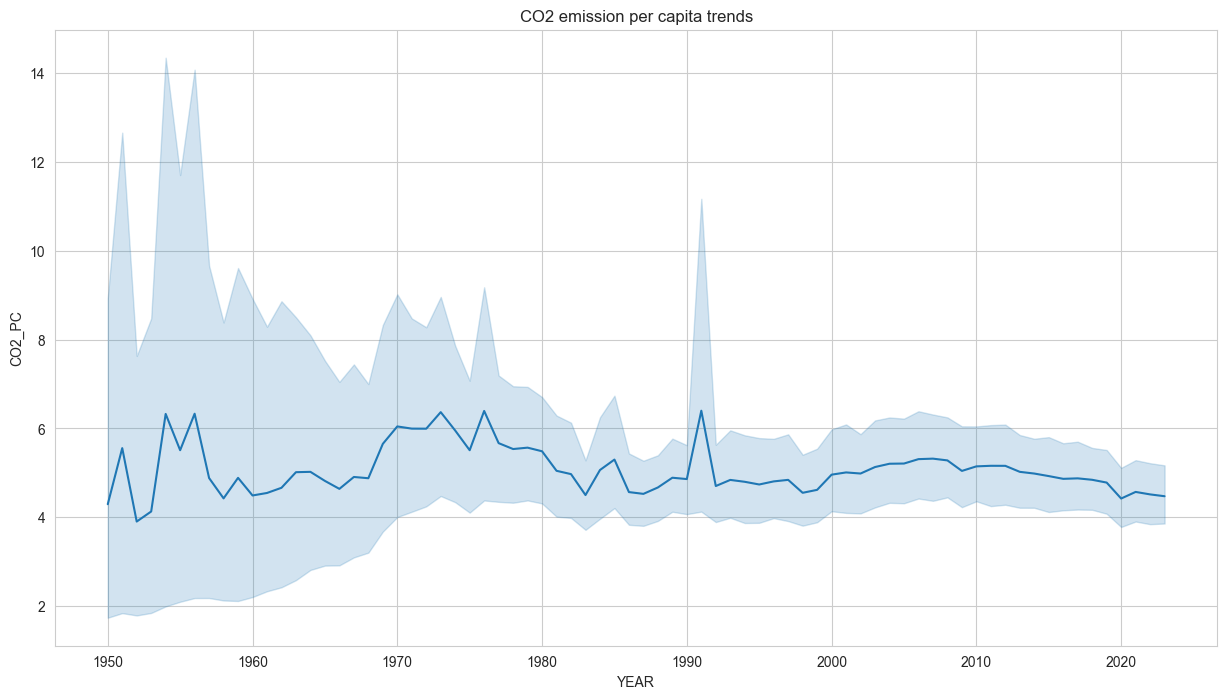

In [160]:

plt.figure(figsize = (15,8))
sns.lineplot(x="YEAR", y="CO2_PC", data=df)
plt.title('CO2 emission per capita trends')
plt.show()

In [161]:


# Filter for 2023
df_2023 = df[df['YEAR'] == 2021]

# Plot using ISO codes
fig = px.choropleth(df_2023,
                    locations='ISO',                
                    locationmode='ISO-3',           
                    color='CO2_PC',                 
                    hover_name='ISO',               
                    color_continuous_scale='Viridis',
                    title='CO2 Emissions Per Capita in 2023')
fig.show()


### Correlation of Co2 emissions with respect to al the features

### correlation heatmap between all the features and labels

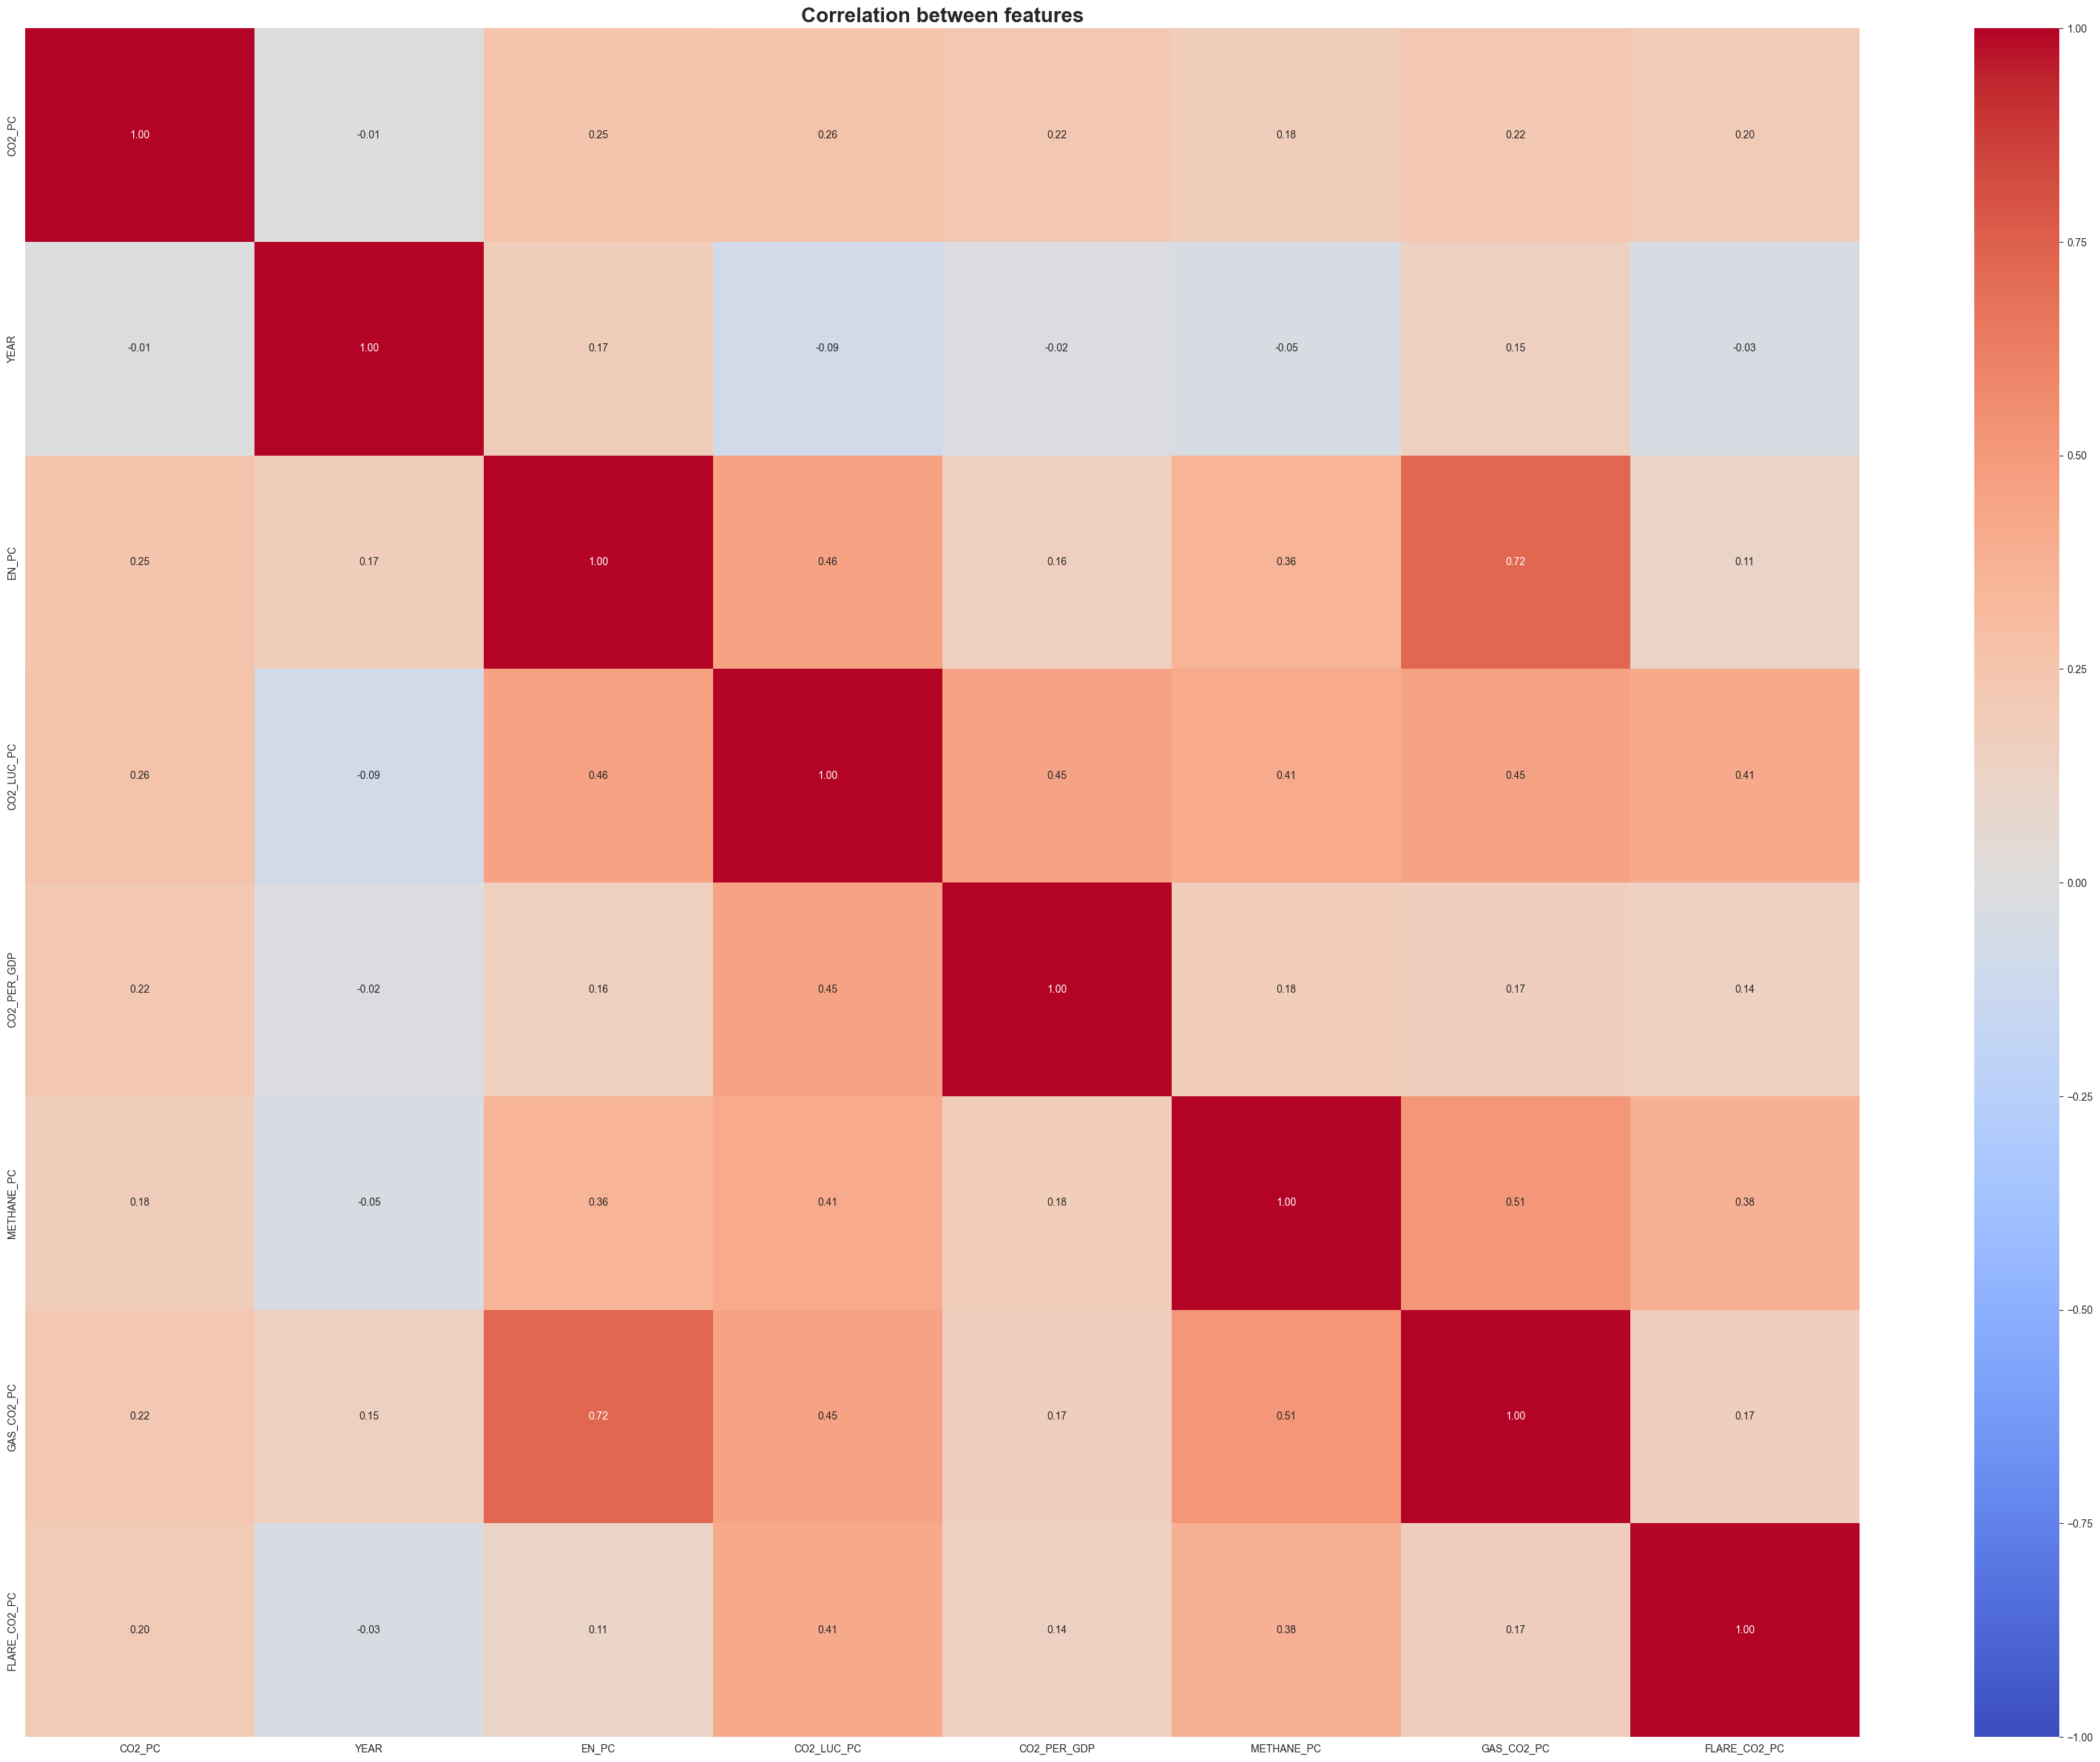

In [162]:
numeric_df = df.select_dtypes(include='number')
f,ax=plt.subplots(figsize=(40,30))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt = ".2f", center=0, vmin=-1, vmax=1)
plt.title('Correlation between features', fontsize=20, weight='bold' )
plt.show()


The accounted algorithms are:
- Linear Regression
- Decision Tree Regression
- Random Forest Regression 
- Support Vector Machine
- CAt boost Regression


## Statistical Data Analysis(SDA), Regression, and Classification:




### Features and label selection 
- Splitting training and test set
   - Splitting of training testing set into X and y

In [203]:
from sklearn.model_selection import train_test_split

prediction_features = [ 'YEAR',
    'GHG',
    'EN_PC',           # Energy per capita
    'CO2_LUC_PC',      # CO2 incl. land-use change per capita
    'CO2_PER_GDP',     # CO2 intensity of GDP
    'METHANE_PC',      # Methane per capita
    'GAS_CO2_PC',      # Gas CO2 per capita
    'FLARE_CO2_PC' ]    # Flaring CO2 per capita]
target = 'CO2_PC'

X = df[prediction_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\nFeature columns:", X_train.columns.tolist())

Training set: 11292 samples
Test set: 4840 samples

Feature columns: ['YEAR', 'GHG', 'EN_PC', 'CO2_LUC_PC', 'CO2_PER_GDP', 'METHANE_PC', 'GAS_CO2_PC', 'FLARE_CO2_PC']


In [204]:
X_train.describe()

,YEAR,GHG,EN_PC,CO2_LUC_PC,CO2_PER_GDP,METHANE_PC,GAS_CO2_PC,FLARE_CO2_PC
count,11292.000000,11292.000000,11292.000000,11292.000000,11292.000000,11292.000000,11292.000000,11292.000000
mean,1986.441552,8.858180,18361.785795,6.357708,0.317963,2.315875,0.705180,0.148953
std,21.354489,10.884629,22220.390529,8.623228,0.835272,5.215922,1.896908,1.621728
min,1950.000000,-6.692000,0.000000,-13.175000,0.000000,0.038000,0.000000,0.000000
25%,1968.000000,3.178000,9156.616000,2.030000,0.171000,0.845000,0.276000,0.000000
50%,1986.000000,5.826500,12379.596000,4.091000,0.246000,1.222000,0.276000,0.000000
75%,2005.000000,10.273000,15470.990500,7.461000,0.321000,1.948000,0.276000,0.001000
max,2023.000000,369.584000,188294.000000,364.706000,82.576000,120.192000,24.180000,60.140000


### Baseline linear regression


### Feature Scaling

- important for optimal predictions in certain algorithms, particularly those sensitive to the scale of input features, such as Linear Regression and Support Vector Regression. It ensures that all features contribute equally to the model. However, algorithms like Decision Tree, Random Forest, and CatBoost are scale-invariant, and thus do not require feature scaling.
- Fitted regularized models

In [ ]:
# from sklearn.preprocessing import FunctionTransformer, StandardScaler
# from sklearn.pipeline    import make_pipeline
# from sklearn.linear_model import Lasso

# def _log_year(df):
#     df = df.copy()
#     df["GDP_PC"] = np.log(df["GDP_PC"].clip(lower=1e-6))
#     df["YEAR"]   = df["YEAR"] - 1970
#     return df

# preprocess = FunctionTransformer(_log_year, validate=False)

# full_pipe = make_pipeline(
#     preprocess,
#     StandardScaler(),
#     Lasso(max_iter=20000)
# )

In [205]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline    import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler



def _log_year(df):
    df = df.copy()
    df["CO2_PER_GDP"] = np.log(df["CO2_PER_GDP"].clip(lower=1e-6))
    df["YEAR"]   = df["YEAR"] - 1970
    return df

base_pipe = make_pipeline(
    FunctionTransformer(_log_year, validate=False),
    StandardScaler(),
    Lasso(max_iter=20_000)
)

# 2.  Time-series CV on TRAIN data only
alphas   = np.arange(0.01, 2.01, 0.01)
tscv     = TimeSeriesSplit(n_splits=5)

cv_mses  = []
coefs    = []

for a in alphas:
    pipe = base_pipe.set_params(lasso__alpha=a)
    
    # cross-validated MSE (negative sign => positive)
    mse = -cross_val_score(pipe, X_train, y_train,
                           scoring="neg_mean_squared_error",
                           cv=tscv).mean()
    cv_mses.append(mse)
    
    # fit once on full training set to record coefficients
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps["lasso"].coef_)


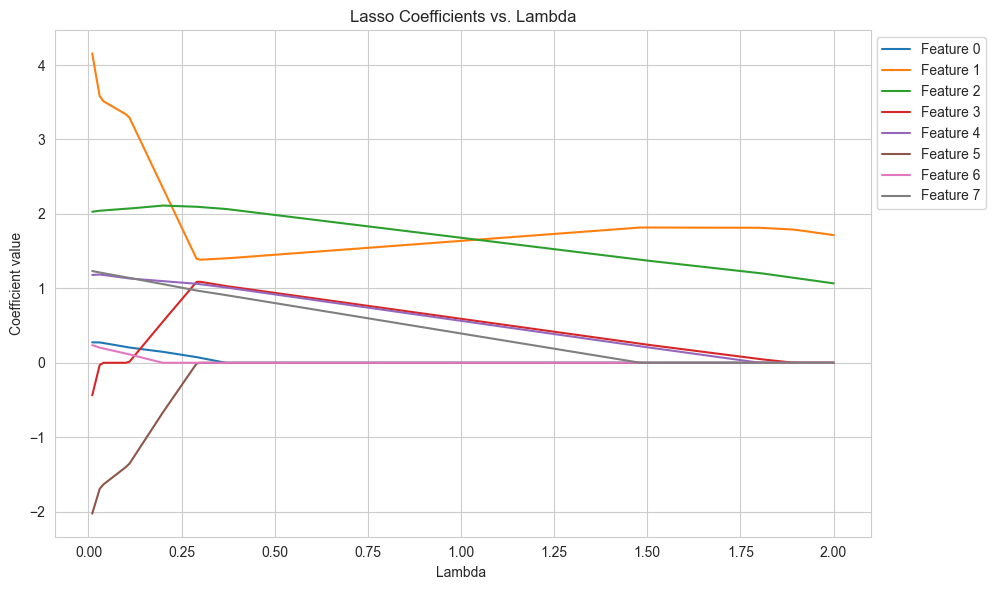

In [206]:
# Convert coefs to a NumPy array for easier slicing
coefs = np.array(coefs)

plt.figure(figsize=(10, 6))

# Plot each feature's coefficient vs. alpha
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Feature {i}')

plt.xlabel('Lambda ')
plt.ylabel('Coefficient value')
plt.title('Lasso Coefficients vs. Lambda')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))  # Optional
plt.grid(True)
plt.tight_layout()
plt.show()

In [207]:
df_plot = pd.DataFrame({"Lambda": alphas, "MSE": cv_mses})
fig = px.line(df_plot, x="Lambda", y="MSE",
              labels={"Lambda": "Lambda ", "MSE": "CV MSE"})
fig.show()


In [208]:

best_idx   = np.argmin(cv_mses)     # index of lowest CV-MSE
best_alpha = alphas[best_idx]
best_mse   = cv_mses[best_idx]

print(f"Best alpha = {best_alpha:.2f}  (CV-MSE = {best_mse:.3f})")

Best alpha = 0.44  (CV-MSE = 45.143)


In [209]:
from sklearn.metrics import mean_squared_error, r2_score
# giving min CV-MSE
best_alpha = 0.17           
pipe_best  = full_pipe.set_params(lasso__alpha=best_alpha)
pipe_best.fit(X_train, y_train)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _log_year at 0x0000012B9A3387C0>)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.17, max_iter=20000))])

In [210]:
y_train_pred = pipe_best.predict(X_train)
y_test_pred  = pipe_best.predict(X_test)


In [212]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

r2_train   = r2_score(y_train, y_train_pred)
r2_test    = r2_score(y_test,  y_test_pred)

print(f"Train RMSE : {rmse_train:.4f} | Test RMSE : {rmse_test:.4f}")
print(f"Train R²   : {r2_train:.4f} | Test R²   : {r2_test:.4f}")

Train RMSE : 5.8536 | Test RMSE : 29.4353
Train R²   : 0.4307 | Test R²   : 0.0577


In [213]:
corr = df[X.columns.tolist() + ['CO2_PC']].corr()['CO2_PC'].abs().sort_values(ascending=False)
print(corr.head(10))	

CO2_PC          1.000000
GHG             0.288566
CO2_LUC_PC      0.262449
EN_PC           0.250665
GAS_CO2_PC      0.223240
CO2_PER_GDP     0.220797
FLARE_CO2_PC    0.198911
METHANE_PC      0.179651
YEAR            0.005313
Name: CO2_PC, dtype: float64


### Ridge(L2-regularization)

In [188]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_pipe.fit(X_train, y_train)
# test set
y_pred_ridge = ridge_pipe.predict(X_test)

In [189]:
#MSE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mse = mean_absolute_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge RMSE: {ridge_rmse:.4f}")
print(f"Ridge MSE: {ridge_mse:.4f}")
print(f"Ridge R²: {r2:.4f}")




Ridge RMSE: 29.4732
Ridge MSE: 3.8478
Ridge R²: 0.0552


In [190]:
# Predict on both training and test sets
y_train_pred = ridge_pipe.predict(X_train)
y_test_pred = ridge_pipe.predict(X_test)

# RMSE
ridge_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
ridge_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# MAE
ridge_mae_train = mean_absolute_error(y_train, y_train_pred)
ridge_mae_test = mean_absolute_error(y_test, y_test_pred)

# R^2
ridge_r2_train = r2_score(y_train, y_train_pred)
ridge_r2_test = r2_score(y_test, y_test_pred)

# Print results
print(" Ridge Regression Performance:")
print(f"Train RMSE: {ridge_rmse_train:.4f} | Test RMSE: {ridge_rmse_test:.4f}")
print(f"Train MAE : {ridge_mae_train:.4f}  | Test MAE : {ridge_mae_test:.4f}")
print(f"Train R^2  : {ridge_r2_train:.4f}   | Test R^2 : {ridge_r2_test:.4f}")


 Ridge Regression Performance:
Train RMSE: 5.4122 | Test RMSE: 29.4732
Train MAE : 2.1910  | Test MAE : 3.8478
Train R^2  : 0.5133   | Test R^2 : 0.0552


In [214]:


# Combine with real values
ridge_pred_df = pd.DataFrame({
    'pred_values': np.round(y_pred_ridge, 3),
    'real_values': np.round(y_test.values, 3)
})

ridge_pred_df.head()

,pred_values,real_values
0,1.720,0.488
1,2.103,0.443
2,2.394,0.455
3,2.191,0.524
4,2.248,0.684


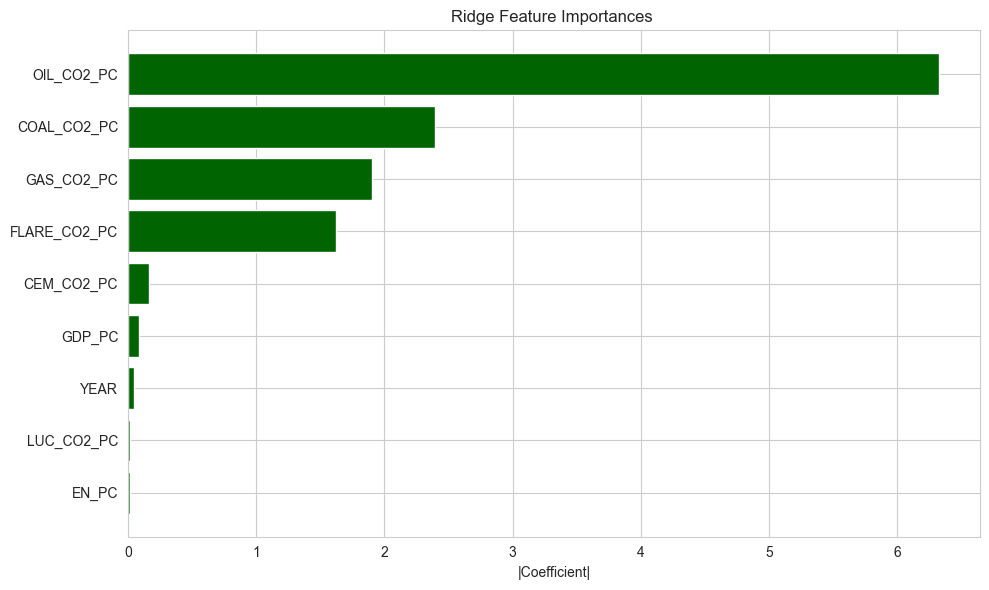

In [ ]:

ridge_model = ridge_pipe.named_steps['ridge']
ridge_coefs = ridge_model.coef_

feature = X.columns
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_coefs})

# Sort by absolute value of coefficients
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['AbsCoefficient'], color='darkgreen')
plt.xlabel('|Coefficient|')
plt.title('Ridge Feature Importances ')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

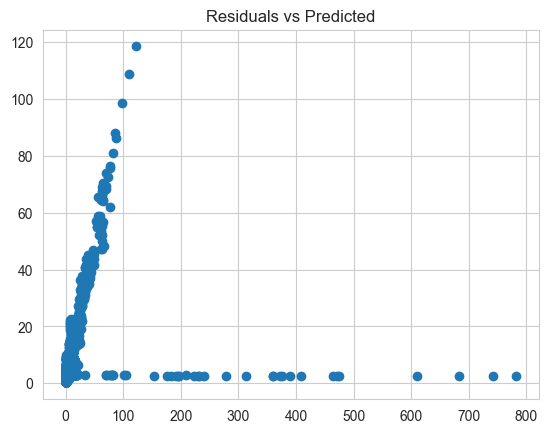

In [ ]:
plt.scatter(y_test, y_test_pred)
plt.title("Residuals vs Predicted")
plt.show()

### Algorithms:

#### XGBoost


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Pipeline with StandardScaler is optional for XGBoost
xgb_model = XGBRegressor(  objective='reg:squarederror',
    n_estimators=1000,
    learning_rate = 0.05,
    early_stopping_rounds=50,
    eval_metric=['rmse', 'mae'],
    random_state=42)
xgb_model.fit( X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True)

y_pred_xgb = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MSE: {xgb_mse:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")

[0]	validation_0-rmse:30.13789	validation_0-mae:6.49035
[1]	validation_0-rmse:29.86018	validation_0-mae:6.28104
[2]	validation_0-rmse:29.59857	validation_0-mae:6.08615
[3]	validation_0-rmse:29.35329	validation_0-mae:5.90499
[4]	validation_0-rmse:29.11996	validation_0-mae:5.72938
[5]	validation_0-rmse:28.90012	validation_0-mae:5.56572
[6]	validation_0-rmse:28.69532	validation_0-mae:5.41014
[7]	validation_0-rmse:28.49432	validation_0-mae:5.26281
[8]	validation_0-rmse:28.29649	validation_0-mae:5.10979
[9]	validation_0-rmse:28.11455	validation_0-mae:4.96637
[10]	validation_0-rmse:27.94427	validation_0-mae:4.83773
[11]	validation_0-rmse:27.77677	validation_0-mae:4.71496
[12]	validation_0-rmse:27.62575	validation_0-mae:4.59912
[13]	validation_0-rmse:27.47926	validation_0-mae:4.48893
[14]	validation_0-rmse:27.34346	validation_0-mae:4.38066
[15]	validation_0-rmse:27.21516	validation_0-mae:4.28378
[16]	validation_0-rmse:27.09626	validation_0-mae:4.18753
[17]	validation_0-rmse:26.98027	validatio

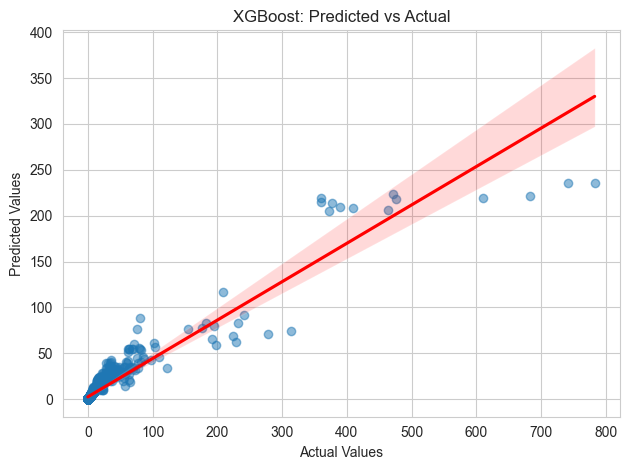

In [ ]:
sns.regplot(x=y_test, y=y_pred_xgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Generate line from real and predicted values
lin_pred = result_pred.rename(columns={0: 'pred_values',1:'real_values'})
lin_pred['pred_values'] = lin_pred['pred_values'].map(lambda x: round(x,3))
# Show comparison
lin_pred

NameError: name 'result_pred' is not defined

In [ ]:

# Error margin
lin_pred['diff'] = abs(lin_pred['pred_values'] - lin_pred['real_values'])
print('mean diff: ', (abs(lin_pred['diff']).mean()))

mean diff:  0.00025905292479109116


<Axes: xlabel='CO2_PC', ylabel='Count'>

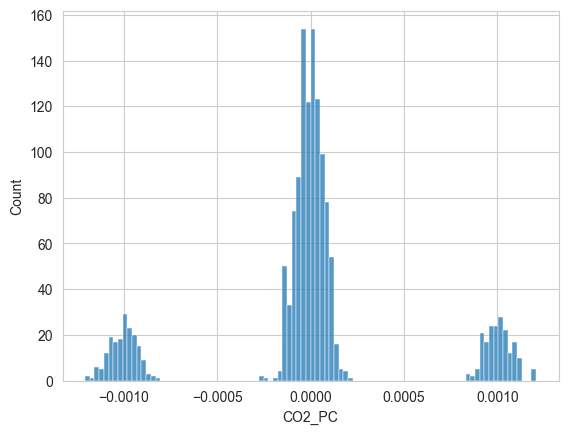

In [ ]:

# Plot test data with predicted data
sns.histplot(y_pred-y_test)

Text(0, 0.5, 'y_pred')

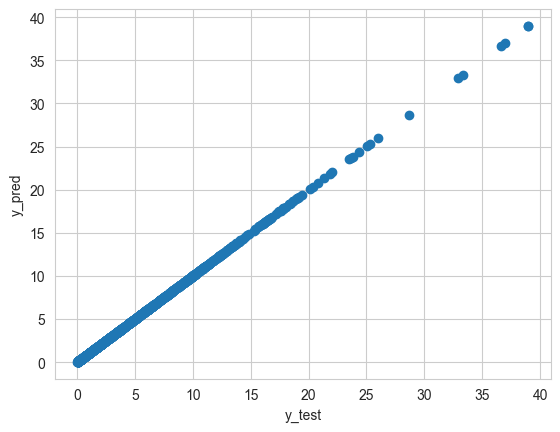

In [ ]:

plt.scatter( y_test,y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')

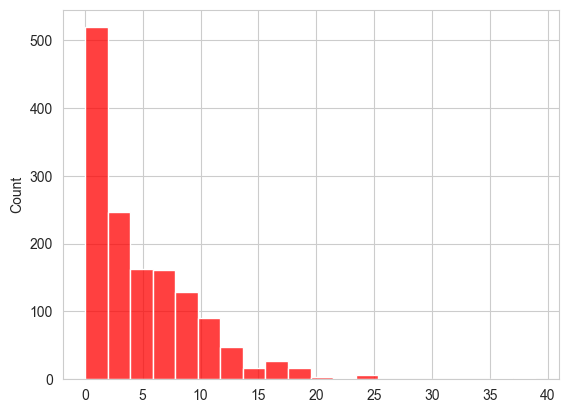

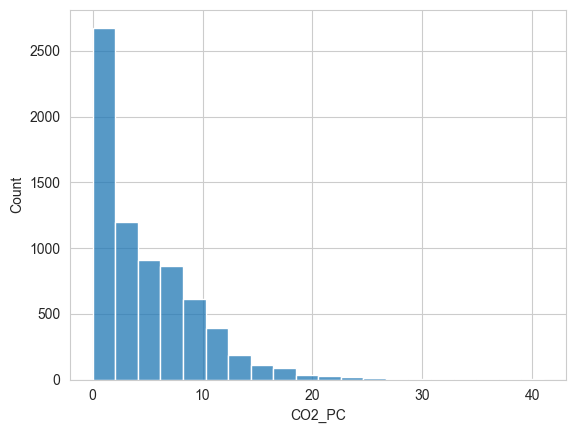

In [ ]:
sns.histplot(y_pred, bins=20,color='red')
plt.show()
sns.histplot(df['CO2_PC'], bins=20)
plt.show()

### Decision Tree Regression


In [ ]:

# Import decision tree regression algorithm from Sklearn
from sklearn.tree import DecisionTreeRegressor
# Train the model
model = make_pipeline(preprocessor, DecisionTreeRegressor())
# 6. Fit model
model.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['YEAR', 'POP', 'CO2_LUC',
                                                   'CO2_LUC_PC', 'COAL_CO2',
                                                   'COAL_CO2_PC', 'OIL_CO2',
                                                   'OIL_CO2_PC', 'CEM_CO2',
                                                   'CEM_CO2_PC', 'LUC_CO2',
                                                   'LUC_CO2_PC', 'CH4',
                                                   'CH4_PC', 'N2O', 'N2O_PC',
                                                   'GHG_PC', 'GHG_TOTAL',
                                                   'TEMP_CHG_GHG',
                                                   'TEMP_CHG_CO2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ISO'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [ ]:

# Make predictions
dtr_pred = model.predict(X_test)
dtr_pred

array([ 0.703, 11.73 ,  0.741, ...,  9.069,  7.008,  3.078])

In [ ]:

# Mean Squared Error
np.sqrt(mean_squared_error(y_test,dtr_pred ))

0.4477700504788698

In [ ]:

# R2 score
r2_score(y_test, dtr_pred)

0.9922736445345994

In [ ]:

# Generate frame from test values and predicted values
frames = [dtr_pred, y_test.values]
result_pred = pd.DataFrame(data=frames)
result_pred = result_pred.T
result_pred.head()


,0,1
0,0.703,0.688
1,11.730,12.324
2,0.741,0.767
3,0.813,0.706
4,17.823,16.490


In [ ]:

# View error margin
dtr_pred = result_pred.rename(columns={0: 'pred_values', 1:'real_values'})
dtr_pred['pred_values'] = (dtr_pred['pred_values'].map(lambda x: round(x,2)))
dtr_pred['diff'] = abs(dtr_pred['real_values'] -dtr_pred['pred_values'])
print('mean diff: ', abs(dtr_pred['diff']).mean())

mean diff:  0.2122339832869081


In [ ]:

# View actual and predicted value difference
dtr_pred.head(10)

,pred_values,real_values,diff
0,0.70,0.688,0.012
1,11.73,12.324,0.594
2,0.74,0.767,0.027
3,0.81,0.706,0.104
4,17.82,16.490,1.330
5,4.84,4.479,0.361
6,1.97,1.806,0.164
7,0.18,0.161,0.019
8,0.24,0.311,0.071
9,2.87,3.308,0.438


### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = make_pipeline(preprocessor, RandomForestRegressor())
# 6. Fit model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['YEAR', 'POP', 'CO2_LUC',
                                                   'CO2_LUC_PC', 'COAL_CO2',
                                                   'COAL_CO2_PC', 'OIL_CO2',
                                                   'OIL_CO2_PC', 'CEM_CO2',
                                                   'CEM_CO2_PC', 'LUC_CO2',
                                                   'LUC_CO2_PC', 'CH4',
                                                   'CH4_PC', 'N2O', 'N2O_PC',
                                                   'GHG_PC', 'GHG_TOTAL',
                                                   'TEMP_CHG_GHG',
                                                   'TEMP_CHG_CO2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ISO'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
# Make predictions
y_rf_pred = rf_model.predict(X_test)
y_rf_pred

array([ 0.70218, 11.78523,  0.79565, ...,  9.2098 ,  7.01309,  3.28133])

In [ ]:
from sklearn.metrics import mean_absolute_error
# Observe quality of the model
print('RMSE: {:0.4f}'.format(np.sqrt(mean_squared_error(y_test,y_rf_pred))))
print('MAE: {:0.4f}'.format(mean_absolute_error(y_test,y_rf_pred)))
print('R2_score: {:0.4f}'.format(r2_score(y_test,y_rf_pred)))


RMSE: 0.2201
MAE: 0.1127
R2_score: 0.9981


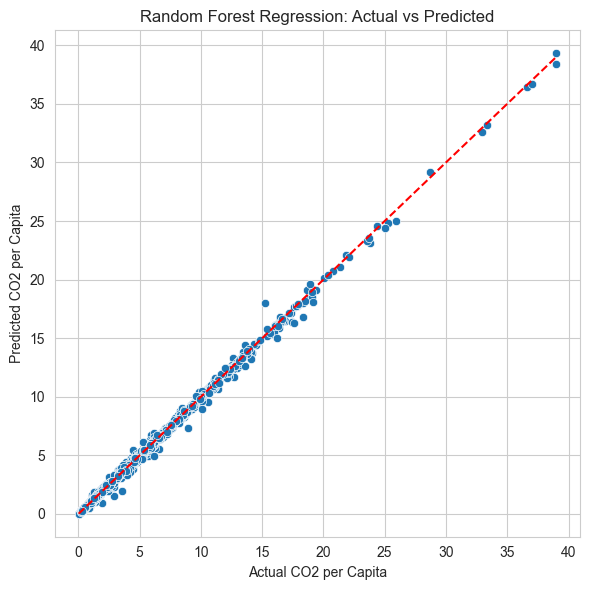

In [ ]:


plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_rf_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.xlabel("Actual CO2 per Capita")
plt.ylabel("Predicted CO2 per Capita")
plt.title("Random Forest Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np

# Define models
models = ['LinReg', 'DT', 'RF', 'SVR', 'CAT']

# Define your preprocessor
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = ['ISO'] if 'ISO' in X.columns else []

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Create empty result DataFrame
frame = pd.DataFrame(columns=[
    'Model', 'RMSE_Train', 'MAE_Train', 'R2_Train',
    'RMSE_Test', 'MAE_Test', 'R2_Test'
])

# Loop through models
for name in models:
    if name == 'LinReg':
        model = make_pipeline(preprocessor, LinearRegression())
        model_name = 'Linear Regression'
    elif name == 'DT':
        model = make_pipeline(preprocessor, DecisionTreeRegressor())
        model_name = 'Decision Tree Regression'
    elif name == 'RF':
        model = make_pipeline(preprocessor, RandomForestRegressor())
        model_name = 'Random Forest Regression'
    elif name == 'SVR':
        model = make_pipeline(preprocessor, LinearSVR(max_iter=10000))
        model_name = 'Support Vector Regression'
    elif name == 'CAT':
        model = CatBoostRegressor(verbose=0, random_state=42)
        model_name = 'CatBoost Regression'

        # Fit CatBoost with categorical features
        model.fit(X_train, y_train, cat_features=['ISO'])

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)

        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        frame.loc[len(frame)] = [
            model_name, rmse_train, mae_train, r2_train,
            rmse_test, mae_test, r2_test
        ]
        continue  # Skip the shared block for CatBoost

    # Shared: fit/predict and evaluate
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    mae_train = mean_absolute_error(y_train, pred_train)
    r2_train = r2_score(y_train, pred_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    mae_test = mean_absolute_error(y_test, pred_test)
    r2_test = r2_score(y_test, pred_test)

    frame.loc[len(frame)] = [
        model_name, rmse_train, mae_train, r2_train,
        rmse_test, mae_test, r2_test
    ]

# Show results
frame

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



,Model,RMSE_Train,MAE_Train,R2_Train,RMSE_Test,MAE_Test,R2_Test
0,Linear Regression,0.000505,0.000296,1.000000,0.000516,0.000303,1.000000
1,Decision Tree Regression,0.000000,0.000000,1.000000,0.402025,0.208940,0.993772
2,Random Forest Regression,0.091122,0.044808,0.999666,0.212475,0.111022,0.998260
3,Support Vector Regression,0.000570,0.000370,1.000000,0.000560,0.000362,1.000000
4,CatBoost Regression,0.111644,0.081729,0.999498,0.218562,0.130569,0.998159


Best model belongs to **CatBoost Regression** and **Random Forest Regression**

### Cross-validation

ValueError: could not convert string to float: 'IRN'